In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import ggplot
import numpy as np
import matplotlib.pyplot as plt
import os.path
import torch
import matplotlib.pylab as pylab
from ipywidgets import interact
from matplotlib.colors import LogNorm

import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

/home/tanguy/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/tanguy/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/tanguy/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import Parameters
import Label
import Save_import

In [3]:
"""organise_CSV import two CSV files and delete all duplicate row. Because the algorithme work with
    mini_batch there is many value for the loss for one epoch and one data set. We compute here the mean
    of all this loss that have the same epoch and data set. We did the same with the confusion matrix
    (0) = name_network : name of the network associated with the CSV file
    (1) = train_number : number of the network associated with the CSV file
"""
def organise_CSV(path_CSV,name_network,train_number, both=True):
    # Import the CSV file into pandas DataFrame
    loss_DF = pd.read_csv(path_CSV + "CSV_loss_" + name_network + str(train_number) + ".csv")
    # This Groupby will regroupe all line that have the same "Set" and "Epoch" and compute the mean over the "Values"
    loss_DF = loss_DF.groupby(['Set','Epoch'])['Value'].mean().reset_index()
    # Recreate the CSV file
    loss_DF.to_csv(path_CSV + "CSV_loss_" + name_network + str(train_number) + ".csv",index = False)
    
    if both:
        # Import the CSV file into pandas DataFrame
        conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")
        # This Groupby will regroupe all line that have the same 'Target','Prediction','Epoch','Set'
        # and compute the mean over the "Values"
        conf_DF = conf_DF.groupby(['Target','Prediction','Epoch','Set'])['Value'].mean().reset_index()
        # Recreate the CSV file
        conf_DF.to_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv",index = False)

In [4]:
"""plot_loss will plot the loss against the epoch
    (0) = name_network : name of the network associated with the CSV file
    (1) = train_number : number of the network associated with the CSV file
"""
def plot_loss(path_CSV,name_network,train_number):
    # Import the CSV file into pandas DataFrame
    loss_DF = pd.read_csv(path_CSV + "CSV_loss_" + name_network + str(train_number) + ".csv")
    
    # Reset sns parameter to default
    sns.set()
    # Set some parameter to have better plot
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (16, 10),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    
    fig, ax = plt.subplots()
    #fig.set_size_inches(15, 10)
    sns.tsplot(time="Epoch", value="Value", data=loss_DF, unit="Set",condition="Set")
    plt.xlabel(r'Value')
    plt.ylabel(r'Loss')
    plt.title("Loss for each epoch")
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 17})
    plt.show()

In [5]:
"""plot_IuO will plot the loss against the epoch
    (other) = labels : All the labels. In 19 different classes to have an user-friendly interact interface.
    If one of this label is True then the line associated is plot.
    (-3) = path_CSV : path of the CSV file
    (-2) = name_network : name of the network associated with the CSV file
    (-1) = train_number : number of the network associated with the CSV file
"""
def plot_IuO_modif(road, sidewalk, building, wall, fence, pole, traffic_light, traffic_sign, vegetation, terrain,
                   sky, person, rider, car, truck, bus, train, motorcycle, bicycle,                  
                   path_CSV,
                   name_network,
                   train_number):
    
    # List of all the label that will be used 
    list_label = [road, sidewalk, building, wall, fence, pole, traffic_light, traffic_sign, vegetation, terrain,
                  sky, person, rider, car, truck, bus, train, motorcycle, bicycle]
    
    # Import the CSV of the conv matrix
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")
    
    # In the column "Value" there is the TP information
    conf_DF_TP = conf_DF[conf_DF["Prediction"] == conf_DF["Target"]]

    # In the column "Value" there is the FN information
    conf_DF_FN = conf_DF.groupby(["Set","Epoch","Target"])["Value"].sum().reset_index()
    # In the column "Value" there is the FP information
    conf_DF_FP = conf_DF.groupby(["Set","Epoch","Prediction"])["Value"].sum().reset_index()

    # Change the name
    conf_DF_FN.rename(columns={"Value": "FN"}, inplace=True)
    conf_DF_FP.rename(columns={"Value": "FP"}, inplace=True)

    # Merge the dataset together according to certain column
    conf_DF_TP_FN = conf_DF_TP.merge(conf_DF_FN, on=["Epoch","Set","Target"])
    conf_DF_TP_FN_FP = conf_DF_TP_FN.merge(conf_DF_FP, on=["Epoch","Set","Prediction"])
    
    # We compute the realFP and FN value, we have to substract the TP values
    conf_DF_TP_FN_FP["FP"] = conf_DF_TP_FN_FP["FP"] - conf_DF_TP_FN_FP["Value"]
    conf_DF_TP_FN_FP["FN"] = conf_DF_TP_FN_FP["FN"] - conf_DF_TP_FN_FP["Value"]
    
    # Compute the IoU each class
    conf_DF_TP_FN_FP["IoU"] = conf_DF_TP_FN_FP["Value"]/(conf_DF_TP_FN_FP["Value"] + 
                                                         conf_DF_TP_FN_FP["FP"] + conf_DF_TP_FN_FP["FN"])
    
    #Change change the name of class for the plot
    conf_DF_TP_FN_FP = conf_DF_TP_FN_FP.merge(parameters.label_DF, left_on='Target', right_on='Class_name')
    
    # Round the Epoch value to have a value  every 10 Epoch. This line could be delete if needed
    conf_DF_TP_FN_FP["Epoch"] = round(conf_DF_TP_FN_FP["Epoch"],-1)
    
    # Regroupe each line that have the same "Set","Epoch","Real_name" and compute the mean fot the IoU
    conf_DF_TP_FN_FP = conf_DF_TP_FN_FP.groupby(["Set","Epoch","Real_name"])["IoU"].mean().reset_index()
    
    # A list of color associated with the labels
    flatui = ["#804080", "#F423E8", "#464646", "#66669C", "#BE9999", "#999999",
             "#FAAA1E", "#DCDC00", "#6B8E23", "#98FB98", "#4682B4", "#DC143C",
             "#FF0000", "#00008E", "#000046", "#003C64", "#005064", "#0000E6",
             "#770B20"]
    
    # List of labels
    label_name = ["road", "sidewalk", "building", "wall", "fence","pole",
                  "traffic light", "traffic sign","vegetation", "terrain", "sky", "person",
                  "rider", "car", "truck", "bus", "train", "motorcycle",
                  "bicycle"]
    
    # frames is a list a dataframe that will be concatenate at the end of the loop
    frames= []
    # Only keep the color needed
    flatui_needed = []
    # The loop over the label look if eachlabel is set to True or False and add the information if Label si True
    for i,label in enumerate(list_label):
        if label:
            frames.append(conf_DF_TP_FN_FP[conf_DF_TP_FN_FP["Real_name"]==label_name[i]])
            flatui_needed.append(flatui[i])
    
    # Concat all the needed DataFrames
    conf_DF_TP_FN_FP = pd.concat(frames)

    # creat 2 areas where the plot will be display, one for each "Set" (most of the time Training and Validation)
    g = sns.FacetGrid(conf_DF_TP_FN_FP, row="Set", size=9)
    
    # IoU against Epoch and a different line for each Real_name. We also add the color and the titles
    g = (g.map_dataframe(sns.tsplot,
                         data=conf_DF_TP_FN_FP,time="Epoch",
                         value="IoU",
                         unit="Real_name", condition="Real_name",
                         color = sns.color_palette(flatui_needed))).set_titles("IoU per classes for both training")
    
    # Define the x axis name and fontsize
    plt.xlabel(r'Epoch',fontsize = 20)
    # Define the y axis name and fontsize
    plt.ylabel(r'IoU',fontsize = 20)
    # Add a legend 
    plt.legend(bbox_to_anchor=(1.2, 1.75), loc=2, borderaxespad=0.,prop={'size': 20})
    
    # Show the plot
    plt.show()
    

In [6]:
def pixel_accuracy(path_CSV, name_network, train_number):
    
    # Import the CSV as DataFrame
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")
    # Select only the usefull epoch
    #conf_DF = conf_DF[conf_DF["Epoch"]==epoch]
    # Keep only the DataSet to display
    #conf_DF = conf_DF[conf_DF["Set"]==data_set]

    # Keep diag values
    conf_diag_DF = conf_DF[conf_DF["Prediction"] == conf_DF["Target"]]

    # Group by Epoch and Set, we get the diagonal
    conf_diag_DF = conf_diag_DF.groupby(['Epoch', 'Set'])["Value"].sum().reset_index()
    # The number of pixel for each Epoch and Set
    conf_DF = conf_DF.groupby(['Epoch', 'Set'])["Value"].sum().reset_index()

    # Divide by the number of pixel for each Epoch and Set
    conf_diag_DF["Value"] = conf_diag_DF["Value"].div(conf_DF["Value"])
    # Reset sns parameter to default
    sns.set()
    # Set some parameter to have better plot
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (16, 10),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    
    fig, ax = plt.subplots()
    #fig.set_size_inches(15, 10)
    sns.tsplot(time="Epoch", value="Value", data=conf_diag_DF, unit="Set",condition="Set")
    plt.xlabel(r'Value')
    plt.ylabel(r'Pixel_accuracy')
    plt.title("Pixel accuracy for each epoch")
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 17})
    plt.show()


In [7]:
"""plot_mat_confusion_modif will plot confusion matrix
    (0) = path_CSV : path to the CSV file where the data are stored
    (0) = name_network : name of the network associated with the CSV file
    (1) = train_number : number of the network associated with the CSV file
    (2) = epoch : Value of the epoch were we want to display the confusion matrix
    (3) = data_set : 
"""
def plot_mat_confusion_modif(path_CSV,name_network,train_number,epoch,data_set,log_scale):
    
    # Import the CSV as DataFrame
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")
    # Select only the usefull epoch
    conf_DF = conf_DF[conf_DF["Epoch"]==epoch]
    # Keep only the DataSet to display
    conf_DF = conf_DF[conf_DF["Set"]==data_set]
    # Define param of union (FalsePositiv, True Negativ, True Positiv)
    FP = [0 for i in range(parameters.number_classes)]
    TN = [0 for i in range(parameters.number_classes)]
    TP = [0 for i in range(parameters.number_classes)]
    
    # Confusion Matrix
    conf_mat_for_plot = np.zeros((parameters.number_classes,parameters.number_classes))
    #Double loop over the confusion matrix the ad each value
    for i in range(parameters.number_classes):
        for j in range(parameters.number_classes):
            conf_mat_for_plot[i,j] = conf_DF.loc[(conf_DF["Prediction"]==("class"+str(i))) &
                                                 (conf_DF["Target"]==("class"+str(j))),"Value"].values

    # Normalize the matrix
    if not log_scale:
        #for i in range(parameters.number_classes):
            #conf_mat_for_plot[i,:] = conf_mat_for_plot[i,:]/sum(conf_mat_for_plot[i,:])
        
        # Round the value to have less number display in the heatmap
        conf_mat_for_plot = np.round(conf_mat_for_plot,0)
        
    else:
        row = 0
        col = 0
        for i in range(parameters.number_classes):
            row += conf_mat_for_plot[i,:]
            col += conf_mat_for_plot[:,i]
        #conf_mat_for_plot = (conf_mat_for_plot/a)*100
        
        # Round the value to have less number display in the heatmap
        conf_mat_for_plot = np.round(conf_mat_for_plot,0)

    conf_mat_for_plot = conf_mat_for_plot.transpose()
    
    # Just change column and row name to make good plot and make the confusion matrix a dataframe
    conf_mat_for_plot = pd.DataFrame(conf_mat_for_plot, columns = ["road","sidewalk","building","wall","fence",
                                                                        "pole","traffic light","traffic sign",
                                                                        "vegetation","terrain","sky","person","rider",
                                                                        "car","truck","bus","train","motorcycle",
                                                                        "bicycle"])
    
    # Rename the rows
    conf_mat_for_plot = conf_mat_for_plot.rename({0 : "road", 1 : "sidewalk", 2 : "building", 3 : "wall",4 : "fence",
                                                  5 : "pole",6 : "traffic light",7 : "traffic sign", 8 : "vegetation",
                                                  9 : "terrain",10 : "sky" ,11 : "person" ,12 : "rider", 13 :"car",
                                                  14 : "truck",15 : "bus",16 : "train",17 : "motorcycle",
                                                  18 : "bicycle"},axis='index')

    # Set the size
    fig, ax = plt.subplots()
    fig.set_size_inches(13, 13)
    conf_mat_for_plot = conf_mat_for_plot.astype(int)
    conf_mat_for_plot[conf_mat_for_plot==0] = float('nan')
    if log_scale:
        #conf_mat_for_plot += 0.1
        sns.heatmap(conf_mat_for_plot,
                    annot=True,
                    ax=ax,
                    square = True,
                    cmap = "Reds",
                    fmt='g',
                    norm=LogNorm(vmin=conf_mat_for_plot.min().min() + 1, vmax=conf_mat_for_plot.max().max()),
                    cbar=False)
    else:
        sns.heatmap(conf_mat_for_plot,
                    annot=True,
                    ax=ax,
                    square = True,
                    cmap = "Reds",
                    fmt='g')
    if False:
        # PLot line to separate True Positif from the error for an example
        plt.plot([0, 17], [2, 2], linewidth=2, color="blue")
        plt.plot([0, 17], [1, 1], linewidth=2, color="blue")
        plt.plot([0, 0], [1, 2], linewidth=2, color="blue")
        plt.plot([17, 17], [1, 2], linewidth=2, color="green")

        plt.plot([18, 19], [2, 2], linewidth=2, color="blue")
        plt.plot([18, 19], [1, 1], linewidth=2, color="blue")
        plt.plot([19, 19], [1, 2], linewidth=2, color="blue")
        plt.plot([18, 18], [1, 2], linewidth=2, color="green")

        plt.plot([17, 17], [2, 19], linewidth=2, color="purple")
        plt.plot([18, 18], [2, 19], linewidth=2, color="purple")
        plt.plot([17, 18], [19, 19], linewidth=2, color="purple")
        plt.plot([17, 18], [2, 2], linewidth=2, color="green")

        plt.plot([18, 18], [0, 1], linewidth=2, color="purple")
        plt.plot([17, 17], [0, 1], linewidth=2, color="purple")
        plt.plot([17, 18], [0, 0], linewidth=2, color="purple")
        plt.plot([17, 18], [1, 1], linewidth=2, color="green")

    #ax.annotate('True Positive', xy=(17.25, 1.25), xytext=(13.75, 0.30), color="green", fontsize=15,
    #        arrowprops=dict(facecolor='green', shrink=0.05))
    #ax.text(16, 8.30, "False Positive", fontsize=15, color = "purple")
    #ax.text(13.75, 1.30, "False Negative", fontsize=15, color = "blue")

    plt.xlabel(r'Prediction',fontsize = 20)
    plt.ylabel(r'Real class',fontsize = 20)
    #plt.title("Confusion matrix of " + data_set + "set for epoch " + str(epoch), fontsize = 20)
    plt.title("Matrice de confusion", fontsize = 20)
    plt.savefig(filename="Matrice_confusion.eps", format='eps',bbox_inches='tight')
    plt.show()

In [8]:
"""plot_IuO will plot the loss against the epoch
    (0) = path_CSV : path of the CSV file
    (1) = name_network : name of the network associated with the CSV file
    (2) = train_number : number of the network associated with the CSV file
"""
def plot_IuO(path_CSV,name_network,train_number):
    
    # Import the CSV of the conv matrix
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")
    
    # In the column "Value" there is the TP information
    conf_DF_TP = conf_DF[conf_DF["Prediction"] == conf_DF["Target"]]

    # In the column "Value" there is the FN information
    conf_DF_FN = conf_DF.groupby(["Set","Epoch","Target"])["Value"].sum().reset_index()
    # In the column "Value" there is the FP information
    conf_DF_FP = conf_DF.groupby(["Set","Epoch","Prediction"])["Value"].sum().reset_index()

    # Change the name
    conf_DF_FN.rename(columns={"Value": "FN"}, inplace=True)
    conf_DF_FP.rename(columns={"Value": "FP"}, inplace=True)

    # Merge the dataset together according to certain column
    conf_DF_TP_FN = conf_DF_TP.merge(conf_DF_FN, on=["Epoch","Set","Target"])
    conf_DF_TP_FN_FP = conf_DF_TP_FN.merge(conf_DF_FP, on=["Epoch","Set","Prediction"])
    
    # We compute the realFP and FN value, we have to substract the TP values
    conf_DF_TP_FN_FP["FP"] = conf_DF_TP_FN_FP["FP"] - conf_DF_TP_FN_FP["Value"]
    conf_DF_TP_FN_FP["FN"] = conf_DF_TP_FN_FP["FN"] - conf_DF_TP_FN_FP["Value"]
    
    # Compute the IoU each class
    conf_DF_TP_FN_FP["IoU"] = conf_DF_TP_FN_FP["Value"]/(conf_DF_TP_FN_FP["Value"] + 
                                                         conf_DF_TP_FN_FP["FP"] + conf_DF_TP_FN_FP["FN"])

    # Round the Epoch value to have a value  every 10 Epoch. This line could be delete if needed
    #conf_DF_TP_FN_FP["Epoch"] = round(conf_DF_TP_FN_FP["Epoch"],-1)
    
    # Regroupe each line that have the same "Set","Epoch","Real_name" and compute the mean fot the IoU
    plot_DF = conf_DF_TP_FN_FP.groupby(["Set","Epoch"])["IoU"].mean().reset_index()
    
    # Start the plot part
    
    # Reset sns parameter to default
    sns.set()
    # Set some parameter to have better plot
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (16, 10),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    
    fig, ax = plt.subplots()
    # Epoch against IoU. A line for each Set
    sns.tsplot(time="Epoch", value="IoU", data=plot_DF, unit="Set",condition="Set")
    # Define the x axis name and fontsize
    plt.xlabel(r'Epoch')
    # Define the y axis name and fontsize
    plt.ylabel(r'IoU mean')
    plt.title("IoU mean for each epoch")
    plt.show() 


In [9]:
parameters=Parameters.Parameters(# Number of columns of the grid
                                 nColumns = 6,
                                 # Number of features map at each rows
                                 nFeatMaps = [8,16,32,64,128],
                                 # Number of feature map of the input image
                                 nFeatureMaps_init = 3,
                                 #Number of classes (19(usefull classes) + 1(all other classes together))
                                 number_classes = 20 - 1,
                                 # DataFrame with the name of each label associated with their number
                                 label_DF = Label.create_label(),

                                 # File where all the parameter model can be store
                                 path_save_net = "Model/",
                                 #Name of the network, used for store (name_network and train_number)
                                 #name_network = "architecture_gpu",
                                 name_network = "cross_to_IoU_scratch",
                                 train_number = 0,
                                 # File where the error will be stored
                                 path_CSV = "CSV/")

name_network = ["focal_loss2","focal_loss", "focal_loss_small",
                "resnet18","resnet18_low_lr",
                "Lovasz","cross_to_IoU_Lovasz", "pretrain_test",
                "better_IoU_approximation","one_image","cross_to_IoU_scratch",
                "hinge_from_cross","IoU_from_cross","IoU_lr_decay",
                "dam_weight_decay_each_batch" ,"IoU_decay_each_batch", "decay_each_epoch",
                "Decay_final", "New_decay", "hinge", "decay6_each_batch",
                "LongTest"]


In [10]:
for i in range(0,1):
    organise_CSV(path_CSV = parameters.path_CSV, name_network = name_network[i],train_number = parameters.train_number,
             both=True)


In [11]:
interact(plot_loss,
         path_CSV = parameters.path_CSV,
         name_network = name_network,
         train_number = parameters.train_number)

<function __main__.plot_loss>

In [12]:
interact(pixel_accuracy,
         path_CSV = parameters.path_CSV,
         name_network = name_network,
         train_number = parameters.train_number)

<function __main__.pixel_accuracy>

In [13]:
interact(plot_IuO,
         path_CSV = parameters.path_CSV,
         name_network = name_network,
         train_number = parameters.train_number)

<function __main__.plot_IuO>

In [14]:
data_set = ["train", "validation"]
epoch_total= [i for i in range(400)]
log_scale = [True,False]

interact(plot_mat_confusion_modif, path_CSV = parameters.path_CSV,
         name_network = name_network,train_number = parameters.train_number,
         epoch = 399,data_set = data_set, log_scale = log_scale)

<function __main__.plot_mat_confusion_modif>

In [15]:
needed = [True,False]
interact(plot_IuO_modif,
         road = needed, sidewalk = needed, building = needed, wall = needed, fence = needed,pole = needed,
         traffic_light = needed, traffic_sign = needed, vegetation = needed, terrain = needed, sky = needed,
         person = needed, rider = needed, car = needed, truck = needed, bus = needed, train = needed,
         motorcycle = needed, bicycle = needed,
         
         title = "Enter a plot title!",
         path_CSV = parameters.path_CSV,
         name_network = name_network,
         train_number = parameters.train_number)

<function __main__.plot_IuO_modif>

# Program that count the number of classes

In [1]:
import GridNet_structure
import Parameters
import Label
import Save_import

from torchvision import transforms
import numpy as np
import os.path
import torch

def count_classes(y_batch, parameters):
    count = np.array([0 for i in range(parameters.number_classes)])
    for i in range(parameters.number_classes):
        count[i] = torch.sum(y_batch == i)
    return(count)

def f():
    # Define all the parameters
    parameters = Parameters.Parameters(nColumns=2,
                                       nFeatMaps=[8, 16],
                                       nFeatureMaps_init=3,
                                       number_classes=20 - 1,
                                       label_DF=Label.create_label(),

                                       width_image_initial=2048, height_image_initial=1024,
                                       size_image_crop=50,

                                       dropFactor=0.1,
                                       learning_rate=0.01,
                                       weight_decay=5 * 10 ** (-6),
                                       beta1=0.9,
                                       beta2=0.999,
                                       epsilon=1 * 10 ** (-8),
                                       batch_size=1,
                                       batch_size_val=8,
                                       epoch_total=200,
                                       actual_epoch=0,
                                       scale=(0.39, 0.5),
                                       ratio=(1, 1),

                                       path_save_net="./Model/",
                                       name_network="IoU_loss8",
                                       train_number=0,
                                       path_CSV="./CSV/",
                                       path_data="/home_expes/collections/Cityscapes/",
                                       #path_data="../Cityscapes_Copy/",
                                       path_print="./Python_print8.txt",
                                       path_result="./Result",
                                       num_workers=2)
    
    parameters.transforms_output = transforms.Compose([transforms.ToTensor()])
    parameters.transforms_input = transforms.Compose([transforms.ToTensor()])
                                      
    
    # Define the GridNet
    network = GridNet_structure.gridNet(nInputs=parameters.nFeatureMaps_init,
                                        nOutputs=parameters.number_classes,
                                        nColumns=parameters.nColumns,
                                        nFeatMaps=parameters.nFeatMaps,
                                        dropFactor=parameters.dropFactor)


    # Import both DataSets with the transformation
    train_dataset = Save_import.CityScapes_final('fine', 'train',
                                                 transform=parameters.transforms_input,
                                                 transform_target=parameters.transforms_output,
                                                 parameters=parameters)
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=parameters.batch_size,
                                               shuffle=True,
                                               num_workers=parameters.num_workers,
                                               drop_last=False)
    
    count = np.array([0 for i in range(parameters.number_classes)])
    
    for i, (x_batch, y_batch, _) in enumerate(train_loader):
        count += count_classes(y_batch,parameters)
    count = count/sum(count)
    print(count)
    return(1/count)
    
a = f()
print(a)

TypeError: __init__() got an unexpected keyword argument 'scale'

# Differente approximation de l'IoU

In [ ]:
import scipy.integrate as integrate
import scipy.special as special

In [ ]:
def IoU_tanguy(x,y,i=0):
    inter = sum(x * y)
    union = sum(x + y) - inter
    return(inter/union)

In [ ]:
def f(x):
    return 2*(x>0.5)

def F(x_0,x_1):
    #print(x_0)
    #print(x_1)
    #print(integrate.quad(f, x_1, x_0)[0])
    return integrate.quad(f, x_1, x_0)[0]

def IoU_article_distrib(x,y,j):
    #print(x)
    liste_1 = [1] * len(x)
    liste_0 = [0] * len(x)
    total = (F(1, x[0])) * (IoU_tanguy(np.array(liste_0),y,j))
    #print((IoU_tanguy(np.array(liste_0),y,j)))

    for i in range(0, len(x) - 1):
        #multi_proba = x[i] #* (1 - y[i]) + (1 - x[i]) * y[i]
        total += (IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j)) * (F(x[i], x[i+1]))
        #print(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]))
        #print(total)
        if j == 20 and False:
            print("new distribution")
            print(i)
            print("total : ",total)
            print("(IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j)) : ",(IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j)))
            print("F(x[i] - x[i+1])", F(x[i], x[i+1]))
    total += (IoU_tanguy(np.array(liste_1),y,j)) * (F(x[-1], 0))
    #print(np.array(liste_1))
    return(total)

In [ ]:
def IoU_article(x,y,j):
    #print(x)
    liste_1 = [1] * len(x)
    liste_0 = [0] * len(x)
    total = (1 - x[0]) * (IoU_tanguy(np.array(liste_0),y,j))
    #print((IoU_tanguy(np.array(liste_0),y,j)))
    #if j == 20:
        #print(x)
    for i in range(0, len(x) - 1):
        #multi_proba = x[i] #* (1 - y[i]) + (1 - x[i]) * y[i]
        total += (IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j)) * (x[i] - x[i+1])
        #print(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]))
        #print(total)
        if j == 40 and False:
            print("basic article")
            print(i)
            print("total : ",total)
            print("(IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j)) : ",
                  (IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j)))
            print("(x[i] - x[i+1])", (x[i] - x[i+1]))
    total += (IoU_tanguy(np.array(liste_1),y,j)) * (x[-1] - 0)
    #print(np.array(liste_1))
    return(total)

In [ ]:
def IoU_lovasz_product(x,y,j):
    #print(x)
    liste_1 = [1] * len(x)
    liste_0 = [0] * len(x)
    total = (IoU_tanguy(np.array(liste_0),y,j)) ** (1 - x[0]) 
    #print((IoU_tanguy(np.array(liste_0),y,j)))
    for i in range(0, len(x) - 1):
        #multi_proba = x[i] #* (1 - y[i]) + (1 - x[i]) * y[i]
        total *= (IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j)) ** (x[i] - x[i+1])
        #print(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]))
        #print(total)
        #if total > 0.5:
            #print(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]))
            #print(y)
    total *= (IoU_tanguy(np.array(liste_1),y,j)) ** (x[-1] - 0)
    #print(np.array(liste_1))
    return(total)

In [ ]:
from random import gauss
import random
import math

sigma = 0.1

def f_temp(x):
    return (1/(math.sqrt(2*math.pi)*sigma))*math.exp(-(1/2)*((x-0.9)**2)/(sigma**2))
    #return((0.5**0.5)-(x-0.5)**0.5)
constante_norm = (integrate.quad(f_temp, 0, 1)[0])

def f(x):
    #return ((0.5**0.5)-(x-0.5)**0.5)/constante_norm
    return (1/(math.sqrt(2*math.pi)*sigma))*math.exp(-(1/2)*((x-(0.9))**2)/(sigma**2))/constante_norm
    #return 5*(x<0.6)*(x>0.4)
print(F(1,0))

def differentIoU(nombre_positif, max_iter, nb_neutre, ecart_type):
    x = np.array([0] * 100)
    liste_1 = [1] * len(x)
    liste_0 = [0] * len(x)
    tanguy = []
    article = []
    part_entiere = []
    Lovasz_product = []
    article_distrib = []
    for i in range(-1, max_iter + 1):
        y = np.array(liste_1[0:nombre_positif] + liste_0[nombre_positif:len(x)])
        a = (0.5*max_iter + i*0.5)/max_iter

        j=0
        indice = a
        x_not_order = []
        while j < len(x):
            g = gauss(indice,ecart_type)
            #g = random.random()*ecart_type - 0.5*ecart_type + indice
            #print(g)
            if 0 <= g <= 1:
                x_not_order.append(g)
                j += 1
                #if j >= nombre_positif - nb_neutre and j <= nombre_positif + nb_neutre:
                #if j == (len(x)-2):
                #    indice = 0.5
                if j >= nombre_positif + nb_neutre:
                    indice = 1 - a
        if i == (max_iter):
            x_not_order = liste_1[0:nombre_positif] + liste_0[nombre_positif:len(x)]
        if i == -1:
            x_not_order = liste_0

        x = np.array(x_not_order)
        #if i ==40:
        #    print(x)
        x_special = x #* (1-y) + (1 - x) * y
        list_indice_sorted = np.argsort(x)
        list_indice_sorted = list_indice_sorted[::-1]
        x = x[list_indice_sorted]
        if i ==40:
            print(x)
        y = y[list_indice_sorted]
        y[1] = 0
        y[-3] = 1
        #list_indice_sorted_special = np.argsort(x_special)
        #list_indice_sorted_special = list_indice_sorted_special[::-1]
        #x_special = x[list_indice_sorted_special]
        #y_special = y[list_indice_sorted_special]
        tanguy.append(IoU_tanguy(x,y,i))
        #Lovasz_product.append(IoU_lovasz_product(x,y,i))
        article.append(IoU_article(x,y,i))
        article_distrib.append(IoU_article_distrib(x,y,i))
        x_part_entiere = [round(j) for j in x]
        part_entiere.append(IoU_tanguy(x_part_entiere,y,i))


    plt.plot(tanguy,label = "tanguy")
    plt.plot(article,label = "article")
    plt.plot(part_entiere,label = "part_entiere")
    #plt.plot(Lovasz_product, label = "Lovasz_product")
    plt.plot(article_distrib, label = "article_distrib")
    plt.legend()
    plt.show()
    


In [2]:
l_ecart_type = [0.001,0.01,0.05,0.1]
interact(differentIoU,
         nombre_positif = 50,
         max_iter = 50,
         nb_neutre = 0,
         ecart_type = l_ecart_type)

NameError: name 'interact' is not defined

In [3]:
plt.plot([f(x/100) for x in range(101)])
#plt.show()

NameError: name 'plt' is not defined

In [4]:
def gradient_article(x,y,j):
    liste_1 = [1] * len(x)
    liste_0 = [0] * len(x)
    total = [(IoU_tanguy(np.array(liste_1[0:1] + liste_0[1:len(x)]),y,j) - 0)]
    for i in range(1, len(x)):
        total.append((IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j) -
                  IoU_tanguy(np.array(liste_1[0:i] + liste_0[i:len(x)]),y,j)))
    return(total)


def gradient_tanguy(x,y,tanguy,i=0):
    inter = sum(x * y)
    union = sum(x + y) - inter
    for k in range(len(x)):
        if y[k] == 0:
            tanguy.append(-1/(union))
        else:
            tanguy.append(-inter/(union))
            
def gradient_tanguy(x,y,tanguy,i=0):
    liste_1 = [1] * len(x)
    liste_0 = [0] * len(x)
    tanguy.append((IoU_tanguy(np.array(liste_1[0:1] + liste_0[1:len(x)]),y,j) - 0)*math.exp(x[0]))
    for i in range(1, len(x)):
        tanguy.append((IoU_tanguy(np.array(liste_1[0:i+1] + liste_0[i+1:len(x)]),y,j) -
                  IoU_tanguy(np.array(liste_1[0:i] + liste_0[i:len(x)]),y,j))*math.exp(x[i]))
    return(tanguy)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
import random

x = np.array([0] * 100)
nombre_positif = 10
liste_1 = [1] * len(x)
liste_0 = [0] * len(x)
tanguy = []
article = []
part_entiere = []
max_iter = 50
max_iter_total = []
k_total = []
for i in range(max_iter):
    y = np.array(liste_1[0:nombre_positif] + liste_0[nombre_positif:len(x)])
    a = (0.5*max_iter + i*0.5)/max_iter
    ecart_type = 0.5
    
    j=0
    indice = a
    x_not_order = []
    while j < len(x):
        #g = gauss(indice,ecart_type)
        g = random.random()*ecart_type - 0.5*ecart_type + indice
        #print(g)
        if 0 <= g <= 1:
            x_not_order.append(g)
            j += 1
            if j >= nombre_positif - 2:
                indice = 0.5
            if j >= nombre_positif + 5:
                indice = 1 - a
    
    x = np.array(x_not_order)
    list_indice_sorted = np.argsort(x)
    list_indice_sorted = list_indice_sorted[::-1]
    x = x[list_indice_sorted]
    y = y[list_indice_sorted]
    gradient_tanguy(x,y,tanguy,i)
    article+=gradient_article(x,y,i)
    k_total+=([a for a in range(len(x))])
    max_iter_total+=[i for j in range(len(x))]
    x_part_entiere = [round(j) for j in x]
    #part_entiere.append(IoU_tanguy(x_part_entiere,y,i))
    
#plt.plot(tanguy,label = "tanguy")
#plt.plot(article,label = "article")
#plt.plot(part_entiere,label = "part_entiere")
#plt.legend()

from mpl_toolkits import mplot3d
fig = plt.figure(1)
ax = plt.axes(projection='3d')  
    
print(len(tanguy))
print(len(max_iter_total))
print(len(k_total))
#ax.plot3D(max_iter_total,k_total, tanguy, 'gray')

#ax.scatter(max_iter_total,k_total, article)
ax.scatter(max_iter_total,k_total, tanguy)

plt.show()
plt.figure(2)
ax = plt.axes(projection='3d')  
ax.scatter(max_iter_total,k_total, article)

#plt.show()

NameError: name 'IoU_tanguy' is not defined

# Work on momentum

In [18]:
lambda_1 = 0.01
a = 0.07
Ireel = [lambda_1]
E_I_t = [0]
for n in range(1000):
    bernoulli = np.random.binomial(1,0.5)
    Ireel.append(Ireel[n] + lambda_1 )#* bernoulli - lambda_1 * (1 - bernoulli))
    E_I_t.append(a*Ireel[n]  + (1-a)*E_I_t[n])
for n in range(1001):
    E_I_t[n] = E_I_t[n] - Ireel[n]
plt.plot([n for n in range(1001)],E_I_t)
#plt.show()

In [19]:
sigma = 1
a = 0.07
t = [sigma**2]
for n in range(1000):
    t.append(sigma**2 * (a)**2 + ((1-(a))**2)*(t[n]))
plt.plot([n for n in range(1001)],np.array(t))
print(variance(a,sigma))
#plt.show()



NameError: name 'variance' is not defined

In [193]:
def variance(a,sigma):
    return((a*(sigma**2))/(2-a))

def EQM(a,sigma,lambda_1):
    return(variance(a,sigma) + (((1-a)*lambda_1)/a)**2)

In [223]:
import sympy
a = sympy.symbols('a')
sigma = sympy.symbols('sigma')
lambd = sympy.symbols('lambd')
EQM = ((1-a)*lambd/a)**2 + (sigma**2)*a/(2-a)
print(sympy.diff(EQM,a))
solution = sympy.solve(EQM,a)

a*sigma**2/(-a + 2)**2 + sigma**2/(-a + 2) + lambd**2*(2*a - 2)/a**2 - 2*lambd**2*(-a + 1)**2/a**3


In [225]:
solution[0]

4*lambd**2/(3*(lambd**2 - sigma**2)) - (16*lambd**4/(lambd**2 - sigma**2)**2 - 15*lambd**2/(lambd**2 - sigma**2))/(3*(-64*lambd**6/(lambd**2 - sigma**2)**3 + 90*lambd**4/(lambd**2 - sigma**2)**2 - 27*lambd**2/(lambd**2 - sigma**2) + sqrt(-4*(16*lambd**4/(lambd**2 - sigma**2)**2 - 15*lambd**2/(lambd**2 - sigma**2))**3 + (-128*lambd**6/(lambd**2 - sigma**2)**3 + 180*lambd**4/(lambd**2 - sigma**2)**2 - 54*lambd**2/(lambd**2 - sigma**2))**2)/2)**(1/3)) - (-64*lambd**6/(lambd**2 - sigma**2)**3 + 90*lambd**4/(lambd**2 - sigma**2)**2 - 27*lambd**2/(lambd**2 - sigma**2) + sqrt(-4*(16*lambd**4/(lambd**2 - sigma**2)**2 - 15*lambd**2/(lambd**2 - sigma**2))**3 + (-128*lambd**6/(lambd**2 - sigma**2)**3 + 180*lambd**4/(lambd**2 - sigma**2)**2 - 54*lambd**2/(lambd**2 - sigma**2))**2)/2)**(1/3)/3

In [20]:
sigma = 0.1
lambda_1 = 0.05
number_iteration = 500
toplot = np.array([EQM(a/number_iteration,sigma,lambda_1) for a in range(1,number_iteration)])
print(np.argmin(toplot)/number_iteration)
plt.plot([(a/number_iteration) for a in range(1,number_iteration)],toplot)
#plt.show()

NameError: name 'EQM' is not defined

In [21]:
l=[1]
l2=[0.1]
momentum1 = 0.99
for i in range(1,1000):
    l.append(l[i-1]*momentum1 + (1-momentum1))
    l2.append(l2[i-1]*0.9 + 0.1)
plt.plot(l)
plt.plot(l2)
#plt.show()

In [153]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import time

x = Variable(torch.FloatTensor([[1,1],[1,1]]), requires_grad=True)

result_global = Variable(torch.zeros(2,2), requires_grad=False)
result_global2 =  Variable(torch.zeros(2,2), requires_grad=False)

for i in range(1000):
    if i > 0:
        x.grad.data.zero_()
    
    y = x
    IoU = 0
    #result_global2 = y * 0.1# + result_global * 0.9
    out_global = Variable(torch.zeros(2), requires_grad=False)
    for k in range(2):
        out_global[k] = torch.sum(y[:,k])

    for i in range(2):
        
        IoU += out_global[i]/(out_global[0])
    IoU.backward(retain_graph=False)

    x.data = x.data - x.grad.data * 0.1
    result_global.data = result_global2.data


In [22]:
lr_init = 0.01
lr_decay = 1*10**-1
lr_epoch = []
a = -0.000045
a = - 4.5 * 10**(-5)
b = 0
for epoch in range(400,800):
    if epoch > 700:
        lr_epoch.append(lr_init/10)
    elif epoch > 500:
        lr_epoch.append(a*(epoch-500) + lr_init)

    else:
        lr_epoch.append(lr_init)

plt.plot(lr_epoch)
#plt.show()

# Number of parameter of GridNet

In [142]:
print("nombre activ",6*353*353*8*(4*3+3*3-2))
print("Go param",6*353*353*8*(4*3+3*3-2)*16/(1024**3))

nombre activ 113643408
Go param 1.6934187412261963


In [152]:
size_image = 401
Ncu = 4
Ncs = 4
Ns = 5
F0 = 16
nombre_image = 7
print("nombre activ",6*size_image*size_image*F0*(4*Ncu+3*Ncs-2))
print("Go activ",6*nombre_image*size_image*size_image*F0*(4*Ncu+3*Ncs-2)*4/(1024**3))

nombre activ 401359296
Go activ 10.466259241104126


In [150]:
print("nombre param",18*2**(2*(Ns-1))*(F0**2)*(4*Ncu + 3*Ncs - 2))
print("Go param",18*2**(2*(Ns-1))*(F0**2)*(4*Ncu + 3*Ncs - 2)*4/(1024**3))

nombre param 30670848
Go param 0.1142578125


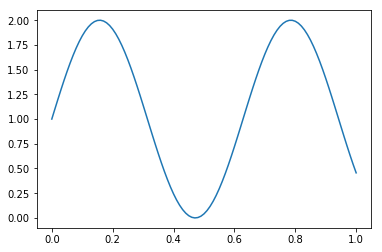

In [28]:
import math
def f_plot(x):
    #return(-(x-0.5)**2)
    return(math.sin(x*10)+1)
x = [i/100 for i in range(101)]
y = [f_plot(i/100)for i in range(101)]
plt.plot(x,y)
plt.show()

# Weight of Gradient

In [ ]:
# proportion of classes in the cityscape dataset
weight_grad=torch.FloatTensor([1., 6.05912619, 1.61538805, 56.25538031,
                                                                          42.02768709, 30.04029159, 177.43320666,
                                                                          66.881359, 2.31467787, 31.84411732,
                                                                          9.17388852, 30.24691356, 272.86243109,
                                                                          5.27120742, 137.85345999, 156.76451618,
                                                                          158.30407732, 373.71255691, 89.07728323]),